In [1]:
import matplotlib.pyplot as plt
import numpy as np
from deepmusic import Music, Track, MusicConfig, utils

## config

In [2]:
config = MusicConfig(
    unit=4,
    min_tempo=40,
    max_tempo=200,
    num_tempo_bins=20, 
    num_velocity_bins=20
)
config

MusicConfig(unit=4, time_signature=(4, 4), tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)

## midi representation

In [3]:
seq = Music.from_file(
    'assets/test.mid', 
    unit=4,
    min_tempo=40,
    max_tempo=200,
    num_tempo_bins=20, 
    num_velocity_bins=20
)
seq

Music(
  name="assets/test.mid", 
  bars=76,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=182, bars=76)
    Track(inst_family=piano, program=0, name="Piano 1", notes=990, bars=76)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=440, bars=73)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=65, bars=75)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=76)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1344, bars=76)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=G_M7)
    ...
  ]
)

In [4]:
seq.config == config

True

### splitting bars

In [5]:
seq.get_bar_count()

76

In [6]:
bars = seq.get_bars()
## dictionary

In [7]:
bars[0], bars[1], bars[2]

(Music(
   name="assets/test.mid - Bar No. 0", 
   bars=1,
   tracks=[],
   tempos=[
     TempoEvent(bar=0, beat=0, tempo=10)
     ...
   ],
   chords=[]
 ),
 Music(
   name="assets/test.mid - Bar No. 1", 
   bars=1,
   tracks=[
     Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=6, bars=1)
   ],
   tempos=[],
   chords=[]
 ),
 Music(
   name="assets/test.mid - Bar No. 2", 
   bars=1,
   tracks=[
     Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=2, bars=1)
     Track(inst_family=piano, program=0, name="Piano 1", notes=16, bars=1)
     Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=6, bars=1)
     Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=4, bars=1)
     Track(inst_family=drums, program=168, name="Drums / Brush", notes=14, bars=1)
   ],
   tempos=[],
   chords=[
     ChordEvent(bar=0, beat=0, chord=G_M7)
     ...
   ]
 ))

## concatenating bars

In [8]:
seq2 = Music.concatenate([bars[0], bars[1], Music(config=config), bars[2]], merge_similar_tracks=True)
## empty music is treated as a single empty bar
seq2

Music(
  name="Concatented : assets/test.mid - Bar No. 0, assets/test.mid - Bar No. 1, , assets/test.mid - Bar No. 2", 
  bars=4,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=2, bars=4)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=14, bars=4)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=4, bars=4)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=12, bars=4)
    Track(inst_family=piano, program=0, name="Piano 1", notes=16, bars=4)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=3, beat=0, chord=G_M7)
    ...
  ]
)

## Slicing

### bar index

In [9]:
seq2 = seq.slice_by_bar(1,2)

In [10]:
seq2 == bars[1]

True

### beat index

In [11]:
seq2 = seq.slice_by_beat(32, 48)
print(seq2 == bars[2])

True


## track manipulation

### remove instruments

In [12]:
seq_t = seq.remove_tracks(programs=[0])
seq_t

Music(
  name="assets/test.mid", 
  bars=76,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=182, bars=76)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=65, bars=75)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=76)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1344, bars=76)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=G_M7)
    ...
  ]
)

In [13]:
seq1 = seq.remove_tracks(inst_families=['piano'], inplace=False)
seq1

Music(
  name="assets/test.mid", 
  bars=76,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=182, bars=76)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=65, bars=75)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=76)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1344, bars=76)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=G_M7)
    ...
  ]
)

### keep instruments

In [14]:
seq2 = seq.keep_tracks(programs=[0], inplace=False)
seq2

Music(
  name="assets/test.mid", 
  bars=76,
  tracks=[
    Track(inst_family=piano, program=0, name="Piano 1", notes=990, bars=76)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=440, bars=73)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=G_M7)
    ...
  ]
)

### Merge

In [15]:
seq_t = Music.merge([seq1, seq2], merge_similar_programs=True)
seq_t == seq

True

### clean

In [16]:
"""
1. remove duplicate and invalid tempos and chords and sort them
2. clean each track
3. remove empty tracks
"""

seq.clean()

### adding empty bars at the beginning

In [26]:
seq_t = seq.pad_left(n=1, inplace=False)
seq_t

Music(
  name="assets/test.mid", 
  bars=77,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=182, bars=77)
    Track(inst_family=piano, program=0, name="Piano 1", notes=990, bars=77)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=440, bars=74)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=65, bars=76)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=77)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1344, bars=77)
  ],
  tempos=[
    TempoEvent(bar=1, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=3, beat=0, chord=G_M7)
    ...
  ]
)

### remove starting silence

In [27]:
seq_t = seq_t.remove_starting_silent_bars()
seq_t == seq

True

### pitch transpose

In [18]:
seq_t = seq.transpose(n=2, inplace=False)
seq_t

Music(
  name="assets/test.mid", 
  bars=76,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=182, bars=76)
    Track(inst_family=piano, program=0, name="Piano 1", notes=990, bars=76)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=440, bars=73)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=65, bars=75)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=76)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1344, bars=76)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=A_M7)
    ...
  ]
)

In [19]:
seq_t.chords[0], seq.chords[0]

(ChordEvent(bar=2, beat=0, chord=A_M7), ChordEvent(bar=2, beat=0, chord=G_M7))

In [20]:
seq_t.tracks[0][0], seq.tracks[0][0]

(NoteEvent(bar=2, beat=0, pitch=45, duration=8, velocity=11),
 NoteEvent(bar=2, beat=0, pitch=43, duration=8, velocity=11))

## exporting

### pianoroll

In [22]:
pianoroll = seq.to_pianoroll(binarize=True)
for k, v in pianoroll.items():
    print(k, v.shape)

(32, 'Bass / Acoust.') (128, 1216)
(0, 'Piano 1') (128, 1216)
(0, 'Melody / Piano 1') (128, 1168)
(49, 'Strings (BB)') (128, 1200)
(24, 'Guitar / Nylon ') (128, 1216)
(168, 'Drums / Brush') (128, 1216)


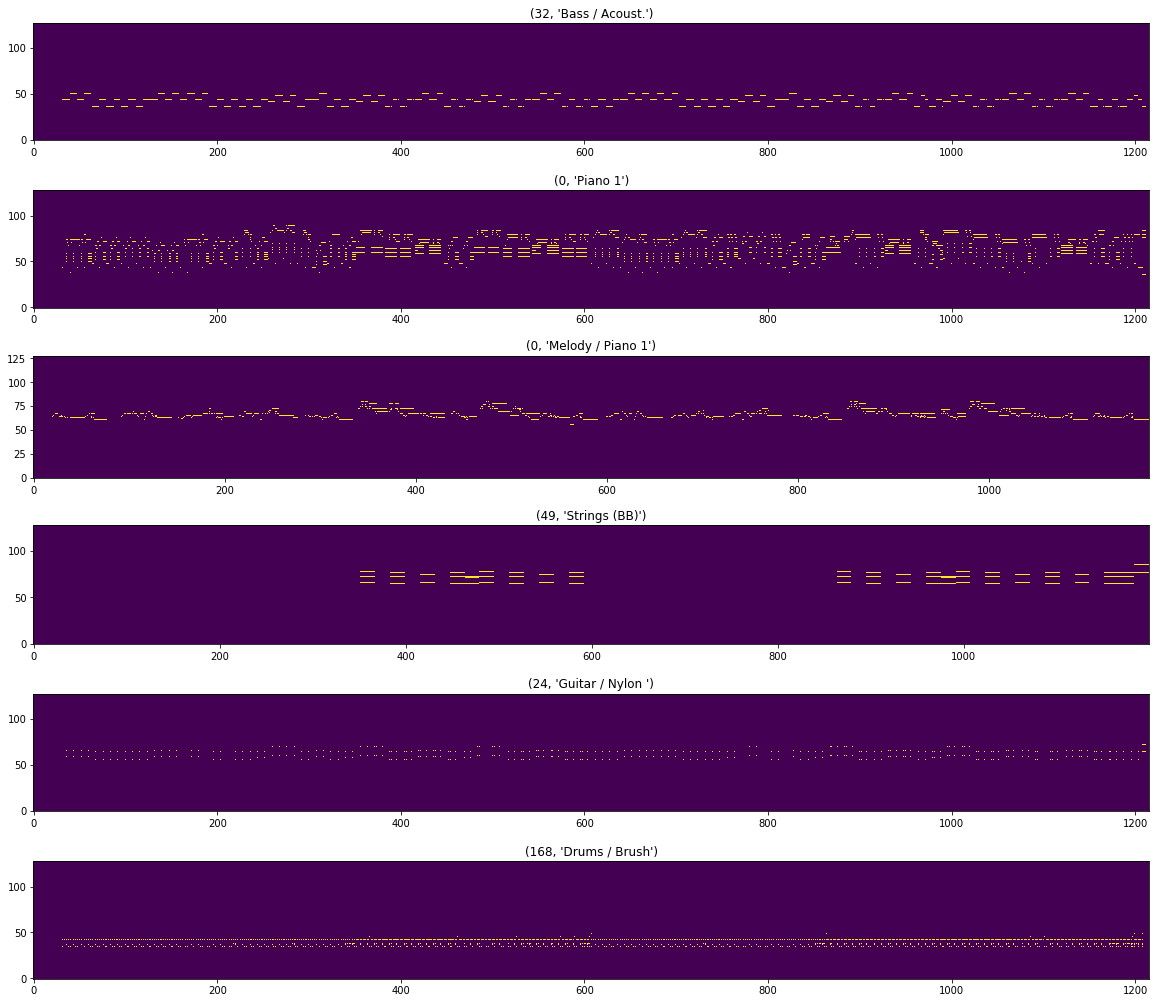

In [28]:
plt.figure(figsize=(20, len(pianoroll)*3))
for i, inst in enumerate(pianoroll):
    plt.subplot(len(pianoroll), 1, i+1)
    plt.title(inst)
    plt.imshow(pianoroll[inst], origin='lower')
plt.show()

### midi

In [24]:
midi = seq.to_midi('assets/rec_test.mid')
midi

ticks per beat: 120
max tick: 36390
tempo changes: 2
time sig: 1
key sig: 0
markers: 70
lyrics: False
instruments: 6

### tokens

In [31]:
toks = seq.to_tokens(
    add_tempo=True, 
    add_chord=True, 
    add_instrument_token=True, 
    add_velocity_token=True, 
    return_indices=False, 
    add_bos=False, 
    add_eos=False
)
toks[:21]

['Bar',
 'Beat_0',
 'Tempo_10',
 'Beat_9',
 'Tempo_7',
 'Bar',
 'Beat_4',
 'NoteInstrument_0',
 'NotePitch_64',
 'NoteDuration_1',
 'NoteVelocity_16',
 'Beat_5',
 'NoteInstrument_0',
 'NotePitch_65',
 'NoteDuration_1',
 'NoteVelocity_13',
 'Beat_7',
 'NoteInstrument_0',
 'NotePitch_67',
 'NoteDuration_3',
 'NoteVelocity_13']

### tuples

In [32]:
tuples = seq.to_tuples()
tuples.shape

(3460, 8)

In [33]:
seq.get_num_notes()+ len(seq.tempos) + len(seq.chords)

3461

In [34]:
tuples[:10]

array([[ 0.,  0., 11.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  8.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  4.,  0.,  0., 64.,  1., 16.,  1.],
       [ 1.,  5.,  0.,  0., 65.,  1., 13.,  1.],
       [ 1.,  7.,  0.,  0., 67.,  3., 13.,  1.],
       [ 1., 11.,  0.,  0., 64.,  3., 11.,  1.],
       [ 1., 13.,  0.,  0., 65.,  1., 12.,  1.],
       [ 1., 14.,  0.,  0., 64.,  1., 14.,  1.],
       [ 2.,  0.,  0., 83.,  0.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0., 43.,  8., 11., 33.]])

## Importing

### from pianoroll

In [35]:
seq_t = Music.from_pianoroll(pianoroll, config=config)
seq_t

Music(
  name="", 
  bars=76,
  tracks=[
    Track(inst_family=bass, program=32, name="Bass / Acoust.", notes=179, bars=76)
    Track(inst_family=piano, program=0, name="Piano 1", notes=969, bars=76)
    Track(inst_family=piano, program=0, name="Melody / Piano 1", notes=401, bars=73)
    Track(inst_family=ensemble, program=49, name="Strings (BB)", notes=55, bars=75)
    Track(inst_family=guitar, program=24, name="Guitar / Nylon ", notes=368, bars=76)
    Track(inst_family=drums, program=168, name="Drums / Brush", notes=1033, bars=76)
  ],
  tempos=[],
  chords=[]
)

In [36]:
seq_t.get_bar_count() == seq.get_bar_count()

True

### from cp

In [37]:
seq_t = Music.from_tuples(tuples, config=config)
seq_t

Music(
  name="", 
  bars=76,
  tracks=[
    Track(inst_family=piano, program=0, name="", notes=1429, bars=76)
    Track(inst_family=bass, program=32, name="", notes=182, bars=76)
    Track(inst_family=drums, program=168, name="", notes=1344, bars=76)
    Track(inst_family=ensemble, program=49, name="", notes=65, bars=75)
    Track(inst_family=guitar, program=24, name="", notes=368, bars=76)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[]
)

### from tokens

In [38]:
seq_t = Music.from_tokens(toks, config=config)
seq_t

Music(
  name="", 
  bars=76,
  tracks=[
    Track(inst_family=piano, program=0, name="", notes=1429, bars=76)
    Track(inst_family=bass, program=32, name="", notes=182, bars=76)
    Track(inst_family=drums, program=168, name="", notes=1344, bars=76)
    Track(inst_family=guitar, program=24, name="", notes=368, bars=76)
    Track(inst_family=ensemble, program=49, name="", notes=65, bars=75)
  ],
  tempos=[
    TempoEvent(bar=0, beat=0, tempo=10)
    ...
  ],
  chords=[
    ChordEvent(bar=2, beat=0, chord=G_M7)
    ...
  ]
)